In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


# PREPROCESSING DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Platinum_Data.csv')
df = df[['Price']]
# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Drop missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

# SPLITTING DATA(7-2-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.3 MB/s eta 0:00:00


In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9141.309, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9134.637, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9135.308, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9135.313, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9132.788, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9137.307, Time=0.63 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.564 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8
 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8
 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8 1091.8]


In [ ]:
# Calculate the accuracy for each model

from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  154.02612963171134
Testing MAE:  139.28376205787777
Testing MAPE:  15.165915466159548
Validation RMSE:  87.65199401120388
Validation MAE:  73.69968152866238
Validation MAPE:  7.467762463451224


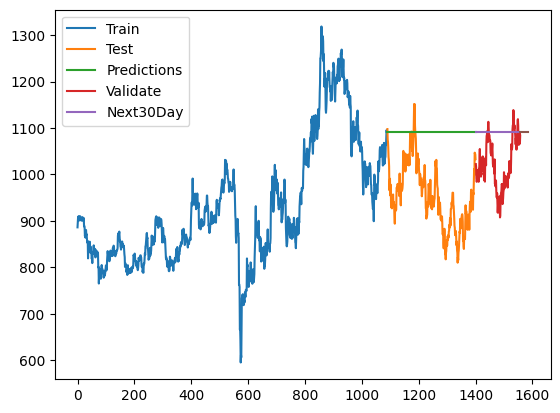

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1090
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4565.394
Date:                Wed, 14 Jun 2023   AIC                           9132.788
Time:                        08:21:54   BIC                           9137.781
Sample:                             0   HQIC                          9134.678
                               - 1090                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       256.3879      6.135     41.789      0.000     244.363     268.413
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):               931.55
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               4.24   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7783.424, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7782.321, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7783.518, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7783.534, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7780.827, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7785.330, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.164 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1
 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1
 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1 1226.1]


In [ ]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  252.89964487931888
Testing MAE:  238.02858672376863
Testing MAPE:  25.00328420386355
Validation RMSE:  211.23849582364093
Validation MAE:  204.6735668789808
Validation MAPE:  20.35318909223765


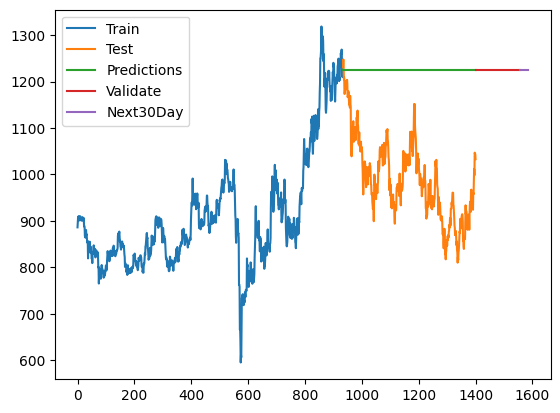

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6380.939, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6381.368, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6382.245, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6382.208, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6379.368, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6382.794, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.266 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6
 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6 887.6
 887.6 887.6 887.6 887.6 887.6 887.6]


In [ ]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  200.65500142907243
Testing MAE:  175.704817987152
Testing MAPE:  15.850721125357598
Validation RMSE:  109.53525293080479
Validation MAE:  89.52820512820512
Validation MAPE:  8.851089740884287


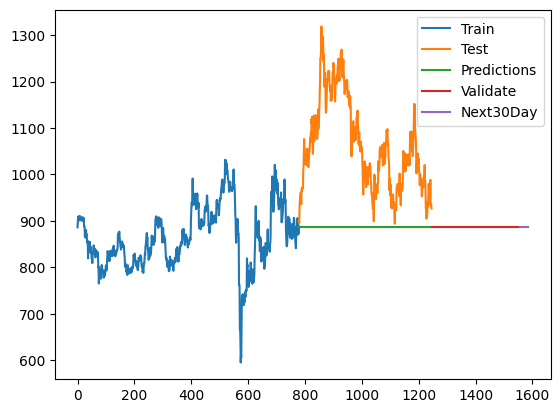

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# EVALUATING MODEL

---
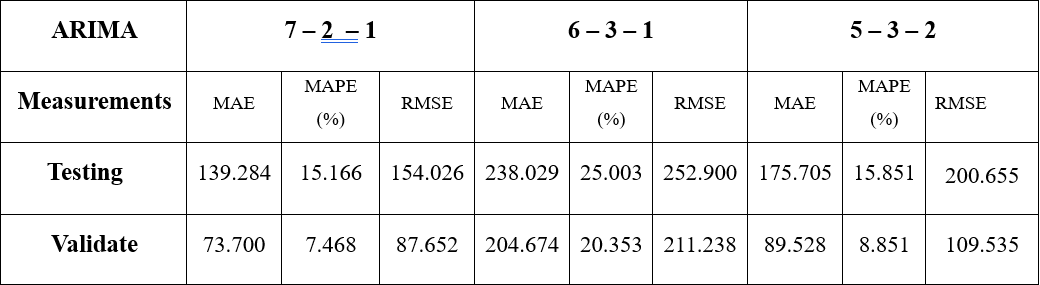
